## **A little touch of Machine Learning... 🤖**

Dans cette phase du projet nous utilisons le Machine Learning pour aller un peu plus loin : 
- **Topic Modeling (LDA)** : Pour extraire les "Sujets Cachés" de la carrière de l'artiste Eminem.
- **Génération de Texte (Markov)** : Pour écrire un faux couplet généré à partir des lyrics à notre disposition. 

### **Chargement et pré-traitement** 🛒 

In [6]:
#Charger les bibliothèques nécessaires
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

In [8]:
# --- 1. CONFIGURATION ---
# Téléchargement des stopwords si ce n'est pas déjà fait
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Ajout de stopwords spécifiques aux paroles (ex: "chorus", "verse")
custom_stopwords = {'chorus', 'verse', 'intro', 'outro', 'eminem', 'shady', 'slim', 'yeah', 'yo', 'like', 'get', 'got'}
stop_words.update(custom_stopwords)

# --- 2. CHARGEMENT ET FILTRAGE ---
df = pd.read_csv("Eminem.csv")

# --- 3. FONCTION DE NETTOYAGE ---
def clean_lyrics(text):
    if not isinstance(text, str):
        return ""
    
    # a. Minuscules
    text = text.lower()
    
    # b. Retirer ce qui est entre crochets [] ou parenthèses () souvent indicatifs (ex: [Chorus])
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\(.*?\)', '', text)
    
    # c. Retirer la ponctuation et les caractères spéciaux
    text = re.sub(r'[^\w\s]', '', text)
    
    # d. Tokenization et retrait des stopwords
    words = text.split()
    clean_words = [w for w in words if w not in stop_words and len(w) > 2]
    
    return " ".join(clean_words)

# On réutilise ta fonction de nettoyage existante
print(f"🔄 Nettoyage de l'ensemble de la discographie ({len(df_full)} titres)...")
df_full['clean_lyrics'] = df_full['Lyric'].apply(clean_lyrics)

# On retire les vides
df_full = df_full[df_full['clean_lyrics'] != ""]
df_full = df_full.reset_index(drop=True)

print(f"✅ Terminé. {len(df_full)} chansons prêtes pour le Machine Learning.")

🔄 Nettoyage de l'ensemble de la discographie (520 titres)...
✅ Terminé. 520 chansons prêtes pour le Machine Learning.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Le Détecteur de Thèmes (LDA)**

Nous allons utiliser l'algorithme LDA (Latent Dirichlet Allocation). C'est une technique statistique qui assume que chaque chanson est un mélange de plusieurs "topics" et que chaque topic est un mélange de mots.

🔍 RÉSULTATS DU TOPIC MODELING :

--- THÈME 1 ---
dont cause aint know fuck youre shit ill bitch say thats man wanna little come


--- THÈME 2 ---
dont cause know think youre say make superman shit stand want fuck feel thats let


--- THÈME 3 ---
dont shit cause aint know bitch fuck fuckin thats time say youre man gonna ill


--- THÈME 4 ---
shit dont cause fuck aint money time 999 thats say know mic goin wanna feature




C:\Users\hp\AppData\Local\Temp\ipykernel_8296\2200030321.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Topic', data=df_full, palette='Set2')


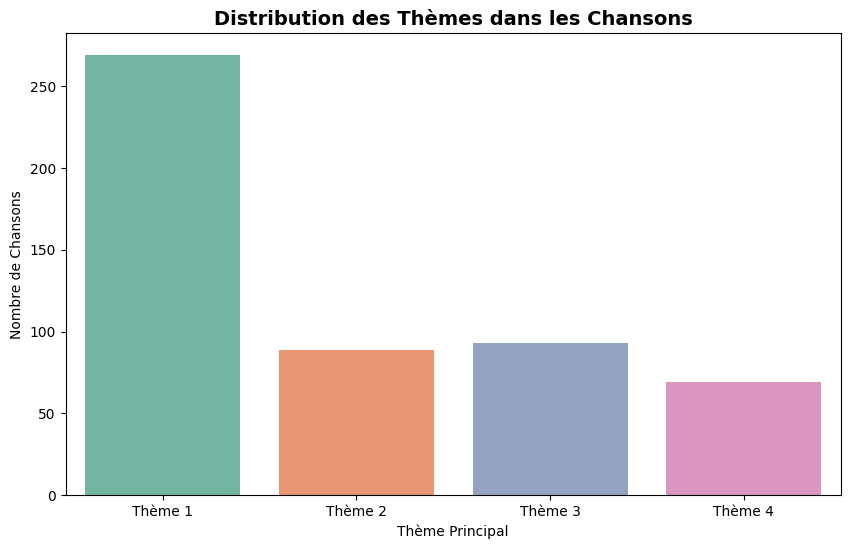

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# --- 1. VECTORISATION ---
# On transforme les mots en matrice de chiffres
# max_df=0.90 : On ignore les mots présents dans plus de 90% des chansons (trop communs)
# min_df=2 : On ignore les mots qui apparaissent dans moins de 2 chansons (trop rares)
tf_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(df_full['clean_lyrics'])

# --- 2. CRÉATION DU MODÈLE LDA ---
n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(tf)

# --- 3. AFFICHAGE DES RÉSULTATS ---
def display_topics(model, feature_names, no_top_words):
    print("🔍 RÉSULTATS DU TOPIC MODELING :\n")
    for topic_idx, topic in enumerate(model.components_):
        print(f"--- THÈME {topic_idx + 1} ---")
        # On récupère les mots avec le plus fort poids dans ce sujet
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")

no_top_words = 15
display_topics(lda, tf_vectorizer.get_feature_names_out(), no_top_words)

# --- 4. HISTOGRAMMES DES 4 THÈMES ---
# On affiche la distribution des thèmes dans les chansons
topic_values = lda.transform(tf)
df_full['Topic'] = topic_values.argmax(axis=1)
plt.figure(figsize=(10,6))
sns.countplot(x='Topic', data=df_full, palette='Set2')
plt.title('Distribution des Thèmes dans les Chansons', fontsize=14, fontweight='bold')
plt.xlabel('Thème Principal')
plt.ylabel('Nombre de Chansons')
plt.xticks(ticks=range(n_topics), labels=[f'Thème {i+1}' for i in range(n_topics)])
plt.show()

### **Étape 3 : Le Générateur de Rap (Chaînes de Markov)** 🎼 
Pour la génération, nous allons utiliser une Chaîne de Markov.

Principe : Si le mot actuel est "Slim", il y a 90% de chances que le prochain soit "Shady". L'algo apprend ces probabilités pour tout le vocabulaire.

Ce n'est pas de l'IA neuronale (comme GPT), c'est purement probabiliste, donc le résultat sera parfois syntaxiquement bizarre, mais très drôle.

In [ ]:
import random
from collections import defaultdict

# --- 1. ENTRAÎNEMENT DU MODÈLE MARKOV ---
# On crée un dictionnaire : { (mot1, mot2) : [liste des mots suivants possibles] }
markov_chain = defaultdict(list)

# On découpe tout le corpus en mots
corpus = ' '.join(df_full['clean_lyrics']).split()

# On parcourt tout le texte par trio de mots
for i in range(len(corpus) - 2):
    current_pair = (corpus[i], corpus[i+1]) # L'état actuel (2 mots)
    next_word = corpus[i+2]                 # Le mot qui suit
    markov_chain[current_pair].append(next_word)

print(f"🧠 Modèle entraîné sur {len(markov_chain)} paires de mots uniques.")

# --- 2. FONCTION DE GÉNÉRATION ---
def generate_rap(length=50):
    # On choisit une paire de départ au hasard 
    start_index = random.randint(0, len(corpus) - 3)
    current_pair = (corpus[start_index], corpus[start_index+1])
    
    generated_text = [current_pair[0], current_pair[1]]
    
    for _ in range(length):
        if current_pair in markov_chain:
            possible_next_words = markov_chain[current_pair]
            next_word = random.choice(possible_next_words)
            generated_text.append(next_word)
            # On avance d'un cran
            current_pair = (current_pair[1], next_word)
        else:
            break # On s'arrête si on tombe sur une impasse
            
    return ' '.join(generated_text)

# --- 3. GÉNÉRATION ---
print("\n🎤 --- GÉNÉRATION D'UN COUPLET INÉDIT (STYLE EMINEM) --- 🎤\n")
print(generate_rap(60))
print("\n" + "="*30)

🧠 Modèle entraîné sur 111366 paires de mots uniques.

🎤 --- GÉNÉRATION D'UN COUPLET INÉDIT (STYLE EMINEM) --- 🎤

kid rock limp bizkit come nowhere start era rock raps harder year ones tryin hear fucking old fart dont want hes cold product moved next schmoe flows nosedove sold nada soap opera told unfolds suppose old partner beat goes dadadom dadom dahdah dahdah better lose music moment better never let one rip gonna make cant give way know star worthwhile every time

